# B.2 Results Analysis

# General Imports

In [2]:
# Analysis
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np

# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
import pickle

# Rid of pesky sk-learn version warnings since we aren't using those variables anyway
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [3]:
def load_dict(filename, verbose=False):
    '''
    Loads dictionary of metrics from given filename
    
    Params:
    - filename (str): file to load
    - verbose=False (bool): sepcifies if exact filename should be used. if False, 
        .pickle extension appended to filename if not already present
    Return
    - dictionary (dict): data found in file
    - None (None): return None val in case exception is raised and dictionary file does not exist
    '''
    # Add .pickle filetype if necessary and requested
    if (not verbose) and ('.pickle' not in filename):
        filename += '.pickle'
    
    # Load file if exists
    try:
        with open(filename, 'rb') as pickle_file: 
            dictionary = pickle.load(pickle_file) 
    except FileNotFoundError as e:
        print(e)
        return None
    
    return dictionary

In [4]:
# Initialize loading variables
data_dict = {}
datasets = ['yelp', 'sub_ob', 'clickbait']
models = ['SVC', 'LogisticRegression', 'RandomForestClassifier', 'nn']
index = 2 # Loads final (of 3) data checkpoint for data

# Load data
for d in datasets:
    for m in models:
        data_dict[(m, d)] = load_dict('../checkpoints/{m}/{m}_{d}_{i}'.format(m=m, d=d, i=index))

# Analysis

In [5]:
TEST_METRICS = ['acc_test', 'precision_test', 'recall_test', 'f1_test']
TRAIN_METRICS = ['acc_train', 'precision_train', 'recall_train', 'f1_train']
DATASETS = ['yelp', 'sub_ob', 'clickbait']

## Test/train set performance (across 3 trials) for each algorithm/dataset combo (Raw + Mean)

In [6]:
def round_values(values, round_to=3):
    '''
    Given a list, or list of list, of values, rounds to a given degree
    Beneficial over list comprehension as it works for nested lists as well
    
    Params:
    - values (list-like): values to round
    - round_to (int): number of significant digits to round to
    
    Returns:
    - new_vals (list-like): rounded values in original structure
    '''
    new_vals = []
    for value in values:
        if type(value) in (list, np.ndarray):
            interior_list = []
            for val in value:
                interior_list.append(round(val, round_to))
            new_vals.append(interior_list)
        else:
            new_vals.append(round(value, 3))
    return new_vals

In [7]:
# Gather the performance per dataset/algo combo as done in the Caruana paper

# Table 1
algo_data_test_dict = {}

# Table 3
algo_data_train_dict = {}

for (algorithm, dataset), metric_dict in data_dict.items():
    # Table 1
    for metric in TEST_METRICS:
        # Take the mean to get the precision, recall, and F1 (since not averaged initially)
        values = [np.mean(metric_dict[(dataset, index)][metric]) for index in range(3)]
        algo_data_test_dict[(algorithm, dataset, metric)] = {'mean': np.mean(values), 
                                                             'values': values, 
                                                             'round_values': round_values(values, 3)}
    # Table 3
    for metric in TRAIN_METRICS:
        values = [metric_dict[(dataset, index)][metric] for index in range(3)]
        algo_data_train_dict[(algorithm, dataset, metric)] = {'mean': np.mean(values), 
                                                              'values': values}

## Mean test set performance (across 3 trials x 3 data sets) for each algorithm

In [8]:
# Gather the performance per algorithm
# First gathers all values (for ttest), and then averages (for table)

# Table 2 p-values
overall_algo_dict = {}

# Table 2 results
mean_algo_dict = {}

# Gather data
for (algorithm, dataset, metric), value_dict in algo_data_test_dict.items():
    try:
        [overall_algo_dict[(algorithm, metric)].append(value) for value in value_dict['values']]
    except KeyError:
        overall_algo_dict[(algorithm, metric)] = value_dict['values']
        
# Average values for each algorithm
for key in overall_algo_dict.keys():
    mean_algo_dict[key] = np.mean(overall_algo_dict[key])

## t-test

In [ ]:
# Get the information on the best performance per metric in order to compute t-tests
datasets = ['yelp', 'sub_ob', 'clickbait']
best_algo_1_dict, best_algo_2_dict, best_algo_3_dict = {}, {}, {}

# Table 5 - Table 1 p-values
best_algo_1_dict['acc_test'] = [np.mean(value) for value 
                                in algo_data_test_dict[('nn', 'clickbait', 'acc_test')]['values']]
best_algo_1_dict['precision_test'] = [np.mean(value) for value 
                                      in algo_data_test_dict[('nn', 'clickbait', 'precision_test')]['values']]
best_algo_1_dict['recall_test'] = [np.mean(value) for value 
                                   in algo_data_test_dict[('nn', 'sub_ob', 'recall_test')]['values']]
best_algo_1_dict['f1_test'] = [np.mean(value) for value 
                               in algo_data_test_dict[('nn', 'clickbait', 'f1_test')]['values']]

# Table 6 - Table 2 p-values
best_algo_2_dict['acc_test'] = overall_algo_dict[('nn', 'acc_test')]
best_algo_2_dict['precision_test'] = overall_algo_dict[('nn', 'precision_test')]
best_algo_2_dict['recall_test'] = overall_algo_dict[('nn', 'recall_test')]
best_algo_2_dict['f1_test'] = overall_algo_dict[('nn', 'f1_test')]

# Table 7 - Table 3 p-values
best_algo_3_dict['acc_train'] = [np.mean(value) for value 
                                 in algo_data_train_dict[('nn', 'clickbait', 'acc_train')]['values']]
best_algo_3_dict['precision_train'] = [np.mean(value) for value 
                                       in algo_data_train_dict[('nn', 'clickbait', 'precision_train')]['values']]
best_algo_3_dict['recall_train'] = [np.mean(value) for value 
                                    in algo_data_train_dict[('nn', 'clickbait', 'recall_train')]['values']]
best_algo_3_dict['f1_train'] = [np.mean(value) for value 
                                in algo_data_train_dict[('nn', 'clickbait', 'f1_train')]['values']]

In [ ]:
# Table 5
# Compares each trial to best performance for each metric
# Loops through all metrics to avoid having to restructure data
for best_metric, best_values in best_algo_1_dict.items():
    for (model, dataset, metric), value_dict in algo_data_test_dict.items():
        if best_metric == metric:
            stat, p = ttest_ind(value_dict['values'], best_values)
            if 0.05 < p < 1:
                print('test: {}\np: {}\n'.format((model, dataset, metric), p))

In [ ]:
# Table 6
# Compares each trial to best performance for each metric
for best_metric, best_values in best_algo_2_dict.items():
    for (algorithm, metric), value_dict in overall_algo_dict.items():
        if best_metric == metric:
            stat, p = ttest_ind(value_dict, best_values)
            print('test: {}\np: {}\n'.format((algorithm, metric), p))

In [ ]:
# Table "7"
# Compares each trial to best performance for each metric
for best_metric, best_values in best_algo_3_dict.items():
    for (model, dataset, metric), value_dict in algo_data_test_dict.items():
        if best_metric == metric:
            stat, p = ttest_ind(value_dict['values'], best_values)
            if 0.05 < p < 1:
                print(model, dataset, metric)
                #print('test: {}\nstat: {}\np: {}'.format((model, dataset, metric), stat, p))

# Note that there is no table 7 in the paper, but this was done to see if there would be any statistical significance 
# during training, even though training performance doesn't mean much in comparison to testing performance

## Heat Maps

In [59]:
def draw_heatmap_1d(accuracies, params, title, ylabel='', save_loc=None):
    '''
    Plots a 1D heatmap over the listed values
    
    Params:
    - accuracies (list-like): accuracy values to plot
    - params (list-like): parameter titles to map accuracy to
    - title (str): title of the plot
    - ylabel='' (str): title of the y-axis
    - save_loc=None (str): specifies where the plot should be saved
    '''
    # Set up the plot
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(accuracies, annot=True, fmt='.3f', yticklabels=params, xticklabels=[])
    ax.collections[0].colorbar.set_label('Accuracy')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    # Add titles
    plt.title(title)
    ax.set(ylabel=ylabel)
    
    # Save and display
    if save_loc:
        plt.savefig(save_loc)
        
    plt.show()

In [51]:
def draw_heatmap_2d(accuracies, dim, x_ticklabels, y_ticklabels, x_label='', y_label='', title='', save_loc=None):
    '''
    Plots a 2D heatmap over the listed accuracies
    
    Params:
    - accuracies (list-like): accuracy values to plot
    - dim (list-like): x, y dimensions
    - x_ticklabels (list-like): list of x-axis value labels
    - y_ticklabels (list-like): list of y-axis value labels
    - x_label (str): label for x-axis
    - y_label (str): label for y_axis
    - title (str): title of the plot
    - save_loc (str): location to save plot to, if not None
    '''
    # Set up the plot
    ax = sns.heatmap(np.array(accuracies).reshape(dim[0], dim[1]), annot=True)
    ax.collections[0].colorbar.set_label('Accuracy')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # X titles
    ax.set_xticklabels(x_ticklabels)
    ax.set_xlabel(x_label)

    # Y titles
    ax.set_yticklabels(y_ticklabels)
    ax.set_ylabel(y_label)
    plt.yticks(rotation=0)
    
    # Title
    plt.title(title)
    
    # Save and display
    if save_loc:
        plt.savefig(save_loc, bbox_inches='tight')
        
    plt.show()

In [10]:
def get_mean(*lists):
    '''
    Computes element-wise mean for each element of the passed in lists. 
    If lists are uneven, shrinks lists to shortest size
    
    Params: 
    - *lists (list-like): lists to perform averaging over
    Returns:
    - list of element-wise means
    '''
    return [np.mean(values) for values in zip(*lists)]

assert get_mean([1,2,3], [4,5,6]) == [2.5,3.5,4.5]
assert get_mean([1,1,1], []) == []
assert get_mean([0,0,0], [2,4,6]) == [1,2,3]

## Logistic Regression

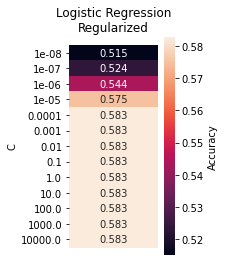

In [60]:
# Gets the list of validation performance for each paremeter combo across all data sets and trials for Logistic Regression
logreg_validation_means = get_mean(*[data_dict[('LogisticRegression', dataset)][(dataset, i)]['cv_results']['mean_test_score'] 
                    for dataset in DATASETS for i in range(3)])[:-1]

logreg_params = [str(value) for value in [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                  0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]]
draw_heatmap_1d(accuracies=np.array(logreg_validation_means).reshape(13,1), 
             params=logreg_params, 
             title='Logistic Regression\nRegularized', 
             ylabel='C',
             save_loc='../images/LogisticRegression/LogisticRegression_regularizations.png')

## Random Forest

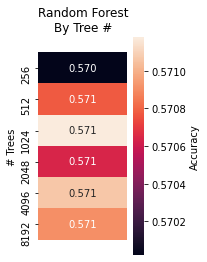

<Figure size 432x288 with 0 Axes>

In [56]:
# Gets the list of validation performance for each paremeter combo across all data sets and trials for Random Forest
rf_validation_means = get_mean(*[data_dict[('RandomForestClassifier', dataset)][(dataset, i)]['cv_results']['mean_test_score'] 
                    for dataset in DATASETS for i in range(3)])[:-1]

rf_params = [str(value) for value in [256, 512, 1024, 2048, 4096, 8192]]
draw_heatmap_1d(accuracies=np.array(rf_validation_means).reshape(6,1), 
             params=rf_params, 
             title='Random Forest\nBy Tree #',
             ylabel='# Trees',
             save_loc='../images/RandomForestClassifier/RandomForestClassifier_trees.png')

## SVM

In [12]:
C_vals = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

### Linear

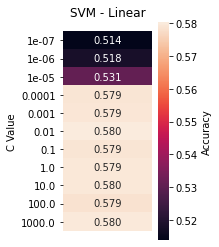

<Figure size 432x288 with 0 Axes>

In [55]:
# Gets the list of validation performance for each paremeter combo across all data sets and trials for SVC

# Get first 11 results, for 11 linear trials
svm_validation_means_linear = get_mean(*[data_dict[('SVC', dataset)][(dataset, i)]['cv_results']['mean_test_score'] 
                    for dataset in DATASETS for i in range(3)])[:11]
svm_params_linear = [str(value) for value in C_vals]

draw_heatmap_1d(accuracies=np.array(svm_validation_means_linear).reshape(11,1), 
             params=svm_params_linear, 
             title='SVM - Linear', 
             ylabel='C Value',
             save_loc='../images/SVC/SVC_linear.png')

### Polynomial

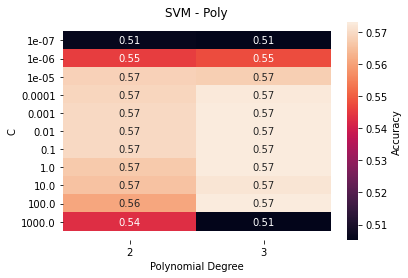

In [58]:
# Gets the list of validation performance for each paremeter combo across all data sets and trials for SVC

# Get 22 poly results (11 trials per poly degree)
svm_validation_means_poly = get_mean(*[data_dict[('SVC', dataset)][(dataset, i)]['cv_results']['mean_test_score'] 
                    for dataset in DATASETS for i in range(3)])[12:34]

# Plot 
x_ticklabels_poly = ['2', '3']
y_ticklabels_poly = [str(value) for value in C_vals]

draw_heatmap_2d(accuracies=svm_validation_means_poly,
               dim=[11, 2],
               x_ticklabels=x_ticklabels_poly,
               y_ticklabels=y_ticklabels_poly,
               x_label='Polynomial Degree',
               y_label='C',
               title='SVM - Poly',
               save_loc='../images/SVC/SVC_poly.png')

### Radial 

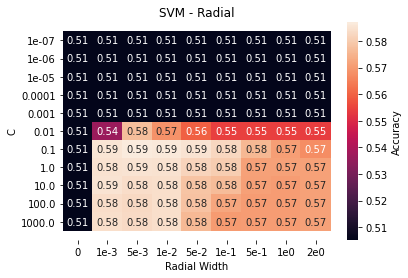

In [53]:
# Gets the list of validation performance for each paremeter combo across all data sets and trials for SVC

# Get 22 poly results (11 trials per poly degree)
svm_validation_means_radial = get_mean(*[data_dict[('SVC', dataset)][(dataset, i)]['cv_results']['mean_test_score'] 
                    for dataset in DATASETS for i in range(3)])[33:]

# Plot
x_ticklabels_radial = ['0', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1e0', '2e0']
y_ticklabels_radial = [str(value) for value in C_vals]

draw_heatmap_2d(accuracies=svm_validation_means_radial, 
                dim=[11, 9], 
                x_ticklabels=x_ticklabels_radial, 
                y_ticklabels=y_ticklabels_radial, 
                x_label='Radial Width', 
                y_label='C', 
                title='SVM - Radial',
                save_loc='../images/SVC/SVC_radial.png')